In [1]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    TargetEncoder,
)
from sklearn.metrics import (
    mean_squared_error,
)

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
import shap

from common import (
    apply_onehot_encoder,
    apply_custom_encoder,
    compare_pipelines,
    grid_search,
    get_linear_regression_scores,
    build_pipeline,
    plot_predictions,
    split,
)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pd.set_option("display.max_colwidth", None)

# Importing the cleaned data

In [3]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,4.946624,Leisure,None,None,60.0,6.858920,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,5.015221,Leisure,ServiceFacility,Leisure,61.0,6.923655,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,5.980508,Leisure,None,None,43.0,7.860859,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,4.787609,Leisure,None,None,56.0,6.832163,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,5.244478,Leisure,ServiceFacility,Leisure,75.0,7.151450,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,ServiceFacility,47.54067,-122.37441,0.30103,4.261548,Leisure,None,None,NaN,5.969455,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1532,ServiceFacility,47.59625,-122.32283,0.30103,4.204147,Leisure,None,None,NaN,5.977850,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1533,ServiceFacility,47.63644,-122.35784,0.30103,4.119190,Leisure,ServiceFacility,Leisure,NaN,6.760867,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1534,ServiceFacility,47.52832,-122.32431,0.30103,4.149281,Leisure,ServiceFacility,School,NaN,5.857014,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


We will set aside a data set that contains energy star score information

In [4]:
energy_data = data.copy()
energy_data = energy_data.loc[~energy_data["ENERGYSTARScore"].isna()]

# Separation of training and test data

In [5]:
y_energy_use = data["SiteEnergyUse(kBtu)"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

In [6]:
(X_train, X_test, y_train, y_test) = split(X, y_energy_use)

Setting a seed value to have reproductible results

In [7]:
np.random.seed(42)

# Baselines

Naive model

In [8]:
mean_prediction = np.mean(y_train)
rmse_mean = np.sqrt(mean_squared_error(y_train, [mean_prediction] * len(y_train)))
print("Mean Prediction:", mean_prediction)
print("RMSE (Mean Model):", rmse_mean)

Mean Prediction: 6.493976186317131
RMSE (Mean Model): 0.5540513837348723


Linear Regression and OneHotEncoder

In [9]:
X_train_onehot, X_test_onehot = apply_onehot_encoder(X_train, X_test, data)

get_linear_regression_scores(X_train_onehot, y_train, X_test_onehot, y_test)

Train R2 score:  0.6599991658888005
Train RMSE score:  0.32135842758286226
Test R2 score:  0.5702695395436913
Test RMSE score:  0.36070144592182934


In [10]:
X_train_custom_encoder, X_test_custom_encoder = apply_custom_encoder(
    X_train, X_test, data
)

get_linear_regression_scores(
    X_train_custom_encoder, y_train, X_test_custom_encoder, y_test
)

Train R2 score:  0.6495910469358417
Train RMSE score:  0.326288998854012
Test R2 score:  0.6238438494976344
Test RMSE score:  0.33711908713643757


Compared to the naive model, a simple LinearRegression already shows significantly better scores. 

The custom encoder, which is the equivalent of a OneHotEncoder condensed into 6 features representing each property use category. The aim was to reduce the number of features that are created by a simple OneHotEncoder.

# Preprocessing 

## Testing preprocessing pipelines

Let's compare the results of a LinearRegression on the train set using different categorical encoders and feature selectors

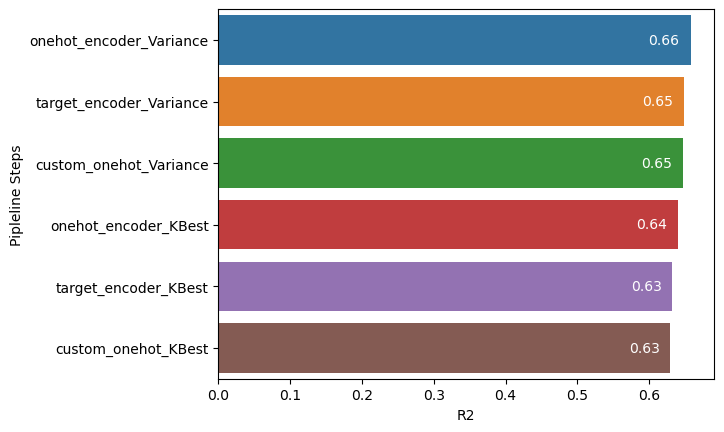

In [11]:
compare_pipelines(X_train, y_train, LinearRegression())

The pipeline that uses the OneHotEncoder, and the Variance feature selection yields the best R2 score on a LinearRegression model. 

We will therefore keep using OneHotEncoder to encode our categorical variables when testing out different models. 

However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values.

---

# Model selection

## Metrics

For the grid search, we will compare three different metrics : R2, RMSE and MAE. 

R2 is easily interpretable, MAE is less impacted by outliers, and RMSE is stricter with large errors.

While we will be looking at all three metrics to interepret results, we aim to predict GHG emissions and energy use and therefore limit the possibility of having large errors. 

The GridSearch will therefore select the best parameters based on the results of the Mean Squared Error.

## GridSearchCV

We will compare three pipelines, two of which will use a feature selector (Variance Threshold and SelectKBest) and one without a selector

In [12]:
model_comparison = pd.DataFrame()

In [13]:
kbest_params = {
    "selectkbest__k": [8, 12, 15, "all"],
    "selectkbest__score_func": [f_regression],
}

variance_params = {"variancethreshold__threshold": [0.1, 0.5, 0.8]}

### Linear Regression

In [14]:
def linear_regression_grid_search(additional_params=None, selector=None):
    param_grid = {}
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X, y_energy_use, LinearRegression(), param_grid, model_comparison, selector
    )


model_comparison = linear_regression_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.566,0.2429,{},0.15,0.9


In [15]:
model_comparison = linear_regression_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55


In [16]:
model_comparison = linear_regression_grid_search(variance_params, VarianceThreshold())

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24


### SVR

#### Without selector

In [17]:
def svr_grid_search(additional_params=None, selector=None):
    param_grid = {
        "svr__C": [10e-2, 10e-1, 0.5, 1, 3],
        "svr__epsilon": [1e-2, 0.5, 1],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(X, y_energy_use, SVR(), param_grid, model_comparison, selector)


model_comparison = svr_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01


#### With SelectKBest Selector

In [18]:
model_comparison = svr_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
4,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75


#### With Variance Threshold Selector

In [19]:
model_comparison = svr_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
4,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
5,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00


### ElasticNet

#### Without selector

In [20]:
def elastic_grid_search(additional_params=None, selector=None):
    param_grid = {
        "elasticnet__alpha": [10e-2, 10e-3, 10e-1, 1],
        "elasticnet__l1_ratio": [1e-2, 1e-1, 0.3, 0.5, 0.8, 1],
        "elasticnet__max_iter": [2000],
        "elasticnet__random_state": [42],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X, y_energy_use, ElasticNet(), param_grid, model_comparison, selector
    )


model_comparison = elastic_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
4,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
5,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
6,ElasticNet(),None,1.177609e+07,0.5459,0.04,0.39,0.6492,0.3288,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42}",0.02,2.46


#### With SelectKBest selector

In [21]:
model_comparison = elastic_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
4,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
5,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
6,ElasticNet(),None,1.177609e+07,0.5459,0.04,0.39,0.6492,0.3288,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42}",0.02,2.46
7,ElasticNet(),SelectKBest(),1.177609e+07,0.5459,0.04,0.38,0.6517,0.3309,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,10.77


#### With VarianceThreshold selector

In [22]:
model_comparison = elastic_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
4,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
5,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
6,ElasticNet(),None,1.177609e+07,0.5459,0.04,0.39,0.6492,0.3288,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42}",0.02,2.46
7,ElasticNet(),SelectKBest(),1.177609e+07,0.5459,0.04,0.38,0.6517,0.3309,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,10.77
8,ElasticNet(),VarianceThreshold(),1.177609e+07,0.5459,0.04,0.29,0.6767,0.3591,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,4.99


### RandomForest

In [23]:
def random_forest_grid_search(additional_params=None, selector=None):
    param_grid = {
        "randomforestregressor__n_estimators": [50, 80, 100],
        "randomforestregressor__min_samples_split": [2, 4, 6],
        "randomforestregressor__criterion": [
            "squared_error",
            "friedman_mse",
            "poisson",
        ],
        "randomforestregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_energy_use,
        RandomForestRegressor(),
        param_grid,
        model_comparison,
        selector,
    )

#### Without selector

In [24]:
model_comparison = random_forest_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
9,RandomForestRegressor(),None,6.797004e+06,0.3468,0.61,0.67,0.5634,0.2401,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.53,73.61
0,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
1,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
2,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
3,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
4,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
5,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
6,ElasticNet(),None,1.177609e+07,0.5459,0.04,0.39,0.6492,0.3288,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42}",0.02,2.46
7,ElasticNet(),SelectKBest(),1.177609e+07,0.5459,0.04,0.38,0.6517,0.3309,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,10.77
8,ElasticNet(),VarianceThreshold(),1.177609e+07,0.5459,0.04,0.29,0.6767,0.3591,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,4.99


#### With SelectKBest selector

In [25]:
model_comparison = random_forest_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,RandomForestRegressor(),None,6.797004e+06,0.3468,0.61,0.67,0.5634,0.2401,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.53,73.61
1,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
10,RandomForestRegressor(),SelectKBest(),7.287930e+06,0.3681,0.57,0.62,0.5812,0.2569,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.38,209.44
2,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
3,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
4,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
5,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
6,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
7,ElasticNet(),None,1.177609e+07,0.5459,0.04,0.39,0.6492,0.3288,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42}",0.02,2.46
8,ElasticNet(),SelectKBest(),1.177609e+07,0.5459,0.04,0.38,0.6517,0.3309,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,10.77


#### With VarianceThreshold selector

In [26]:
model_comparison = random_forest_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,RandomForestRegressor(),None,6.797004e+06,0.3468,0.61,0.67,0.5634,0.2401,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.53,73.61
1,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
2,RandomForestRegressor(),SelectKBest(),7.287930e+06,0.3681,0.57,0.62,0.5812,0.2569,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.38,209.44
3,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
4,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
5,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
6,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
7,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
11,RandomForestRegressor(),VarianceThreshold(),1.148591e+07,0.5725,-0.05,0.42,0.6382,0.3120,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.8}",0.29,119.21
8,ElasticNet(),None,1.177609e+07,0.5459,0.04,0.39,0.6492,0.3288,"{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 2000, 'elasticnet__random_state': 42}",0.02,2.46


### Gradient Boosting

#### Without Selector

In [27]:
def gradient_boosting_grid_search(additional_params=None, selector=None):
    param_grid = {
        "gradientboostingregressor__n_estimators": [80, 100, 120],
        "gradientboostingregressor__loss": [
            "squared_error",
            "absolute_error",
            "huber",
        ],
        "gradientboostingregressor__min_samples_split": [2, 4, 6],
        "gradientboostingregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_energy_use,
        GradientBoostingRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = gradient_boosting_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
12,GradientBoostingRegressor(),None,6.572108e+06,0.3233,0.66,0.67,0.5627,0.2407,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 80, 'gradientboostingregressor__random_state': 42}",0.35,48.43
0,RandomForestRegressor(),None,6.797004e+06,0.3468,0.61,0.67,0.5634,0.2401,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.53,73.61
1,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
2,RandomForestRegressor(),SelectKBest(),7.287930e+06,0.3681,0.57,0.62,0.5812,0.2569,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.38,209.44
3,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
4,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
5,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
6,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
7,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00
8,RandomForestRegressor(),VarianceThreshold(),1.148591e+07,0.5725,-0.05,0.42,0.6382,0.3120,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.8}",0.29,119.21


#### With SelectKBest Selector


In [28]:
model_comparison = gradient_boosting_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,GradientBoostingRegressor(),None,6.572108e+06,0.3233,0.66,0.67,0.5627,0.2407,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 80, 'gradientboostingregressor__random_state': 42}",0.35,48.43
1,RandomForestRegressor(),None,6.797004e+06,0.3468,0.61,0.67,0.5634,0.2401,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.53,73.61
2,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
3,RandomForestRegressor(),SelectKBest(),7.287930e+06,0.3681,0.57,0.62,0.5812,0.2569,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.38,209.44
4,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
13,GradientBoostingRegressor(),SelectKBest(),8.028822e+06,0.3426,0.62,0.65,0.5715,0.2469,"{'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.27,150.10
5,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
6,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
7,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75
8,SVR(),VarianceThreshold(),1.136795e+07,0.5374,0.07,0.29,0.6787,0.3636,"{'svr__C': 0.1, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.8}",0.02,5.00


#### With VarianceThreshold selector

In [29]:
model_comparison = gradient_boosting_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,GradientBoostingRegressor(),None,6.572108e+06,0.3233,0.66,0.67,0.5627,0.2407,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 80, 'gradientboostingregressor__random_state': 42}",0.35,48.43
1,RandomForestRegressor(),None,6.797004e+06,0.3468,0.61,0.67,0.5634,0.2401,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.53,73.61
2,LinearRegression(),None,7.069873e+06,0.3173,0.68,0.66,0.5660,0.2429,{},0.15,0.90
3,RandomForestRegressor(),SelectKBest(),7.287930e+06,0.3681,0.57,0.62,0.5812,0.2569,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.38,209.44
4,LinearRegression(),SelectKBest(),7.943052e+06,0.3354,0.64,0.64,0.5727,0.2469,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.02,0.55
5,GradientBoostingRegressor(),SelectKBest(),8.028822e+06,0.3426,0.62,0.65,0.5715,0.2469,"{'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x162f37eb0>}",0.27,150.10
14,GradientBoostingRegressor(),VarianceThreshold(),1.110600e+07,0.5054,0.18,0.48,0.6242,0.2984,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.8}",0.17,68.65
6,LinearRegression(),VarianceThreshold(),1.113682e+07,0.5085,0.17,0.46,0.6288,0.3037,{'variancethreshold__threshold': 0.8},0.01,0.24
7,SVR(),None,1.127042e+07,0.5282,0.11,0.39,0.6528,0.3369,"{'svr__C': 0.1, 'svr__epsilon': 1}",0.02,2.01
8,SVR(),SelectKBest(),1.127042e+07,0.5282,0.11,0.42,0.6444,0.3264,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x162f37eb0>, 'svr__C': 0.1, 'svr__epsilon': 1}",0.03,12.75


The results of the model comparison show that the RandomForest Model yields the best RMSE score in kBtu units. This suggests that errors in energy use predictions with the Random Forest model will be smaller than with other models. 

However, the GradientBoostingRegressor has a better R2 score, a lower RMSE log value, along with a slightly lower fit time on average. Taking all these parameters into account, it seems that the GradientBoostingRegressor will yield better predictions than the RandomForestRegressor. 

---

# Feature Importance

In [30]:
pipeline = make_pipeline(
    make_column_transformer(
        (
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            make_column_selector(dtype_include=object),
        ),
        remainder="passthrough",
    ),
    RobustScaler(),
)

In [31]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.fit_transform(X_test)

In [32]:
model = GradientBoostingRegressor(
    loss="absolute_error",
    min_samples_split=2,
    n_estimators=80,
    random_state=42,
)
model.fit(X_train_transformed, y_train)
model.score(X_test_transformed, y_test)

0.6637006399454315

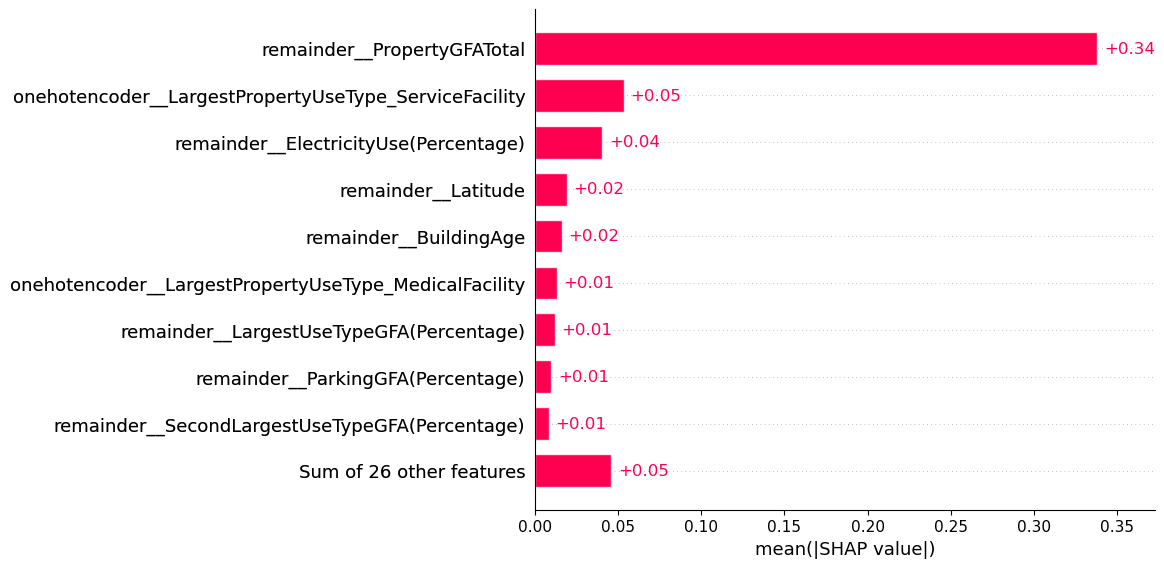

In [33]:
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(
    pd.DataFrame(X_test_transformed,
                 columns=pipeline[:-1].get_feature_names_out())
)

shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


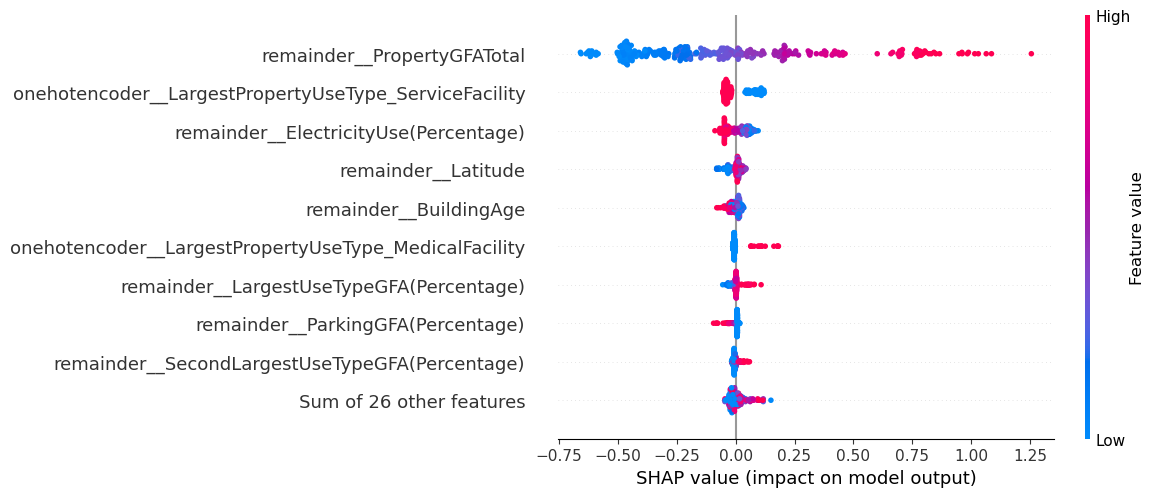

In [34]:
shap.plots.beeswarm(shap_values)

This feature importance analysis suggests that the surface of the building, along with its age, the percentage of electricity use, along with whether its main use is in a medical or service capacity, are the information that contribute the most to the model in order to make accurate predictions.

---

# EnergyStarScore

In [35]:
y = energy_data["SiteEnergyUse(kBtu)"]
X_with_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
    ],
    axis=1,
)
X_without_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

(
    X_train_wo_score,
    X_test_wo_score,
    y_train_wo_score,
    y_test_wo_score,
) = train_test_split(X_without_score, y, test_size=0.2, random_state=42)

(
    X_train_with_score,
    X_test_with_score,
    y_train_with_score,
    y_test_with_score,
) = train_test_split(X_with_score, y, test_size=0.2, random_state=42)

### Testing with Gradient Boosting Regressor

First we get a baseline measure of our model without the EnergyStarScore

In [36]:
ess_comparison = pd.DataFrame()


def gradient_boosting_grid_search(X, y, df):
    param_grid = {
        "gradientboostingregressor__n_estimators": [100, 200, 300, 400],
        "gradientboostingregressor__loss": [
            "squared_error",
            "absolute_error",
            "huber",
        ],
        "gradientboostingregressor__min_samples_split": [6, 8, 10],
        "gradientboostingregressor__max_features": ["sqrt", "log2", 1.0],
        "gradientboostingregressor__random_state": [42],
    }

    return grid_search(
        X,
        y,
        GradientBoostingRegressor(),
        param_grid,
        df,
    )


ess_comparison = gradient_boosting_grid_search(X_without_score, y, ess_comparison)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,GradientBoostingRegressor(),None,1.215411e+07,0.2787,0.71,0.71,0.5425,0.2202,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__random_state': 42}",0.24,133.57


We can now compare these results with a grid search on the data set that contains the EnergyStarScore information

In [37]:
ess_comparison = gradient_boosting_grid_search(X_with_score, y, ess_comparison)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,GradientBoostingRegressor(),None,1.215411e+07,0.2787,0.71,0.71,0.5425,0.2202,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__random_state': 42}",0.24,133.57
1,GradientBoostingRegressor(),None,1.415486e+07,0.2561,0.75,0.78,0.5066,0.1884,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__random_state': 42}",0.26,141.58


The training mean R2 is higher with the ESS features, but the test scores only show a slight increase. Nonetheless, the ESS does seem to provide additional information that helps better predict energy use, which makes sense since the score is based on the energy use. 

Overall, the score does not seem to be worth collecting given these results. Further feature engineering might help get similar results.